# Importing required libraries

In [ ]:
pip install catboost

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install scikit-plot

In [ ]:
pip install optuna

In [ ]:
!pip install scipy==1.9.3


In [ ]:
pip install dask

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt

import optuna

import tensorflow as tf

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Data Loading

In [ ]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


# Data PreProcessing

we have to drop the unnecessary columns here we can find the customerid remove that

In [ ]:
data.drop('customerID', axis=1, inplace= True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


we have to Find unique values in a column helps understand data diversity, identify inconsistencies, and prepare data for analysis and modeling.

In [ ]:
print(data['SeniorCitizen'].unique())
print(data['TotalCharges'].nunique())

[0 1]
6531


we have to do the required type castings and have to handle the NAn values

In [ ]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.NaN) # This column had missing values represented by ' '. I noticed it when I tried converting it to float and it gave me an error that it could not convert string to float
data['TotalCharges'] = data['TotalCharges'].astype(float)
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

understanding unique values

In [ ]:
unique_values = {column: list(data[column].unique()) for column in data.select_dtypes(object).columns}
for key, value in unique_values.items():
    print(f'{key} : {value}')

gender : ['Female', 'Male']
SeniorCitizen : ['0', '1']
Partner : ['Yes', 'No']
Dependents : ['No', 'Yes']
PhoneService : ['No', 'Yes']
MultipleLines : ['No phone service', 'No', 'Yes']
InternetService : ['DSL', 'Fiber optic', 'No']
OnlineSecurity : ['No', 'Yes', 'No internet service']
OnlineBackup : ['Yes', 'No', 'No internet service']
DeviceProtection : ['No', 'Yes', 'No internet service']
TechSupport : ['No', 'Yes', 'No internet service']
StreamingTV : ['No', 'Yes', 'No internet service']
StreamingMovies : ['No', 'Yes', 'No internet service']
Contract : ['Month-to-month', 'One year', 'Two year']
PaperlessBilling : ['Yes', 'No']
PaymentMethod : ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn : ['No', 'Yes']


# **Standardizing Categorical Features**

In [ ]:
data['MultipleLines'] = data['MultipleLines'].replace('No phone service', 'No')
data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
      'TechSupport', 'StreamingTV', 'StreamingMovies']] = data[['OnlineSecurity', 'OnlineBackup',
                                                                'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies']].replace('No internet service', 'No')

In [ ]:
unique_values = {column: list(data[column].unique()) for column in data.select_dtypes(object).columns}
for key, value in unique_values.items():
    print(f'{key} : {value}')

gender : ['Female', 'Male']
SeniorCitizen : ['0', '1']
Partner : ['Yes', 'No']
Dependents : ['No', 'Yes']
PhoneService : ['No', 'Yes']
MultipleLines : ['No', 'Yes']
InternetService : ['DSL', 'Fiber optic', 'No']
OnlineSecurity : ['No', 'Yes']
OnlineBackup : ['Yes', 'No']
DeviceProtection : ['No', 'Yes']
TechSupport : ['No', 'Yes']
StreamingTV : ['No', 'Yes']
StreamingMovies : ['No', 'Yes']
Contract : ['Month-to-month', 'One year', 'Two year']
PaperlessBilling : ['Yes', 'No']
PaymentMethod : ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn : ['No', 'Yes']


In [ ]:
data['tenure'].value_counts(ascending= False)

,count
tenure,
1,613
72,362
2,238
3,200
4,176
...,...
28,57
39,56
44,51


handling missing values in the columns

this is one example, we can apply this to the columns according to our needs

In [ ]:
data['tenure']  = data['tenure'].replace(0, np.NaN)
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

In [ ]:
data['Churn'].value_counts()


,count
Churn,
No,5174
Yes,1869


this means we are having churn yes as 1869 among 7043 and no as 5174 amoing 7043

In [ ]:
data['tenure'].value_counts()

,count
tenure,
1.0,613
72.0,362
2.0,238
3.0,200
4.0,176
...,...
38.0,59
28.0,57
39.0,56


# **Feature Scaling**

we can do lot of things like Exploratory data analysis and feature scaling ...etc

In [ ]:
# Feature Scaling for numeric columns

from sklearn.preprocessing import StandardScaler

# Columns to be scaled
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Convert 'TotalCharges' to numeric, handle errors
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Fill missing values in 'TotalCharges' with the median value
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Standard Scaling
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Display the first few rows to check scaled values
print(data[numeric_cols].head())


     tenure  MonthlyCharges  TotalCharges
0 -1.281012       -1.160323     -0.994242
1  0.064570       -0.259629     -0.173244
2 -1.240236       -0.362660     -0.959674
3  0.513097       -0.746535     -0.194766
4 -1.240236        0.197365     -0.940470


# **Feature Engineering**

# Exploratory Data Analysis

In [ ]:
# Feature Engineering - Create tenure groups
data['tenure_group'] = pd.cut(data['tenure'], bins=[0, 12, 24, 48, 60, 72],
                              labels=['0-12', '12-24', '24-48', '48-60', '60-72'])

# Display the first few rows to check the tenure group
print(data[['tenure', 'tenure_group']].head())

# Create interaction terms (Optional - advanced feature engineering)
data['MonthlyCharges_Tenure_Interaction'] = data['MonthlyCharges'] * data['tenure']

# Check the interaction term
print(data[['MonthlyCharges', 'tenure', 'MonthlyCharges_Tenure_Interaction']].head())


     tenure tenure_group
0 -1.281012          NaN
1  0.064570         0-12
2 -1.240236          NaN
3  0.513097         0-12
4 -1.240236          NaN
   MonthlyCharges    tenure  MonthlyCharges_Tenure_Interaction
0       -1.160323 -1.281012                           1.486387
1       -0.259629  0.064570                          -0.016764
2       -0.362660 -1.240236                           0.449785
3       -0.746535  0.513097                          -0.383045
4        0.197365 -1.240236                          -0.244780


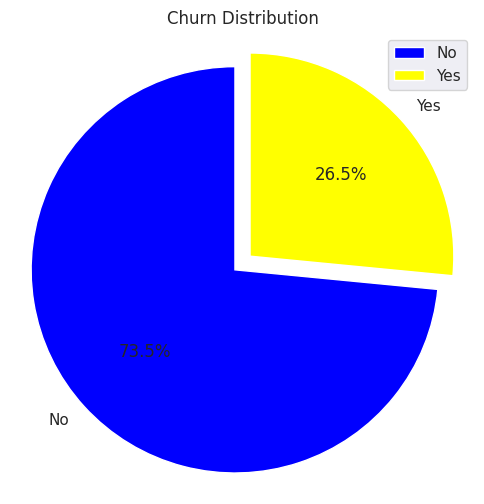

In [ ]:

# Count the occurrences of 'Churn'
churn_counts = data['Churn'].value_counts()

# Pie Chart with explode
plt.figure(figsize=(6, 6))
explode = [0.1 if label == 'Yes' else 0 for label in churn_counts.index]  # Explode the 'Yes' (churned) slice
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, explode=explode, colors=['blue', 'yellow'])
plt.title('Churn Distribution')
plt.legend()
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

<ipython-input-26-153dd0252d41>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=['orange', 'green'])


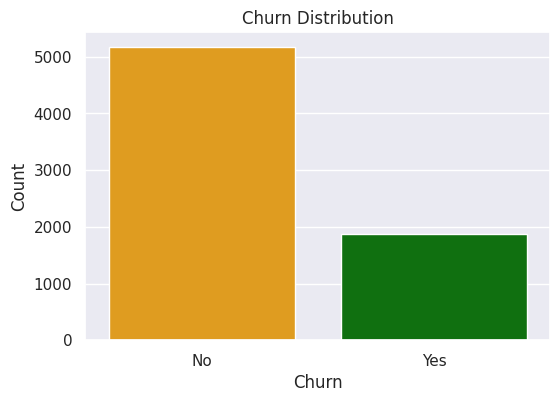

In [ ]:

# Count the occurrences of 'Churn'
churn_counts = data['Churn'].value_counts()

# Bar Plot with custom colors
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=['orange', 'green'])
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


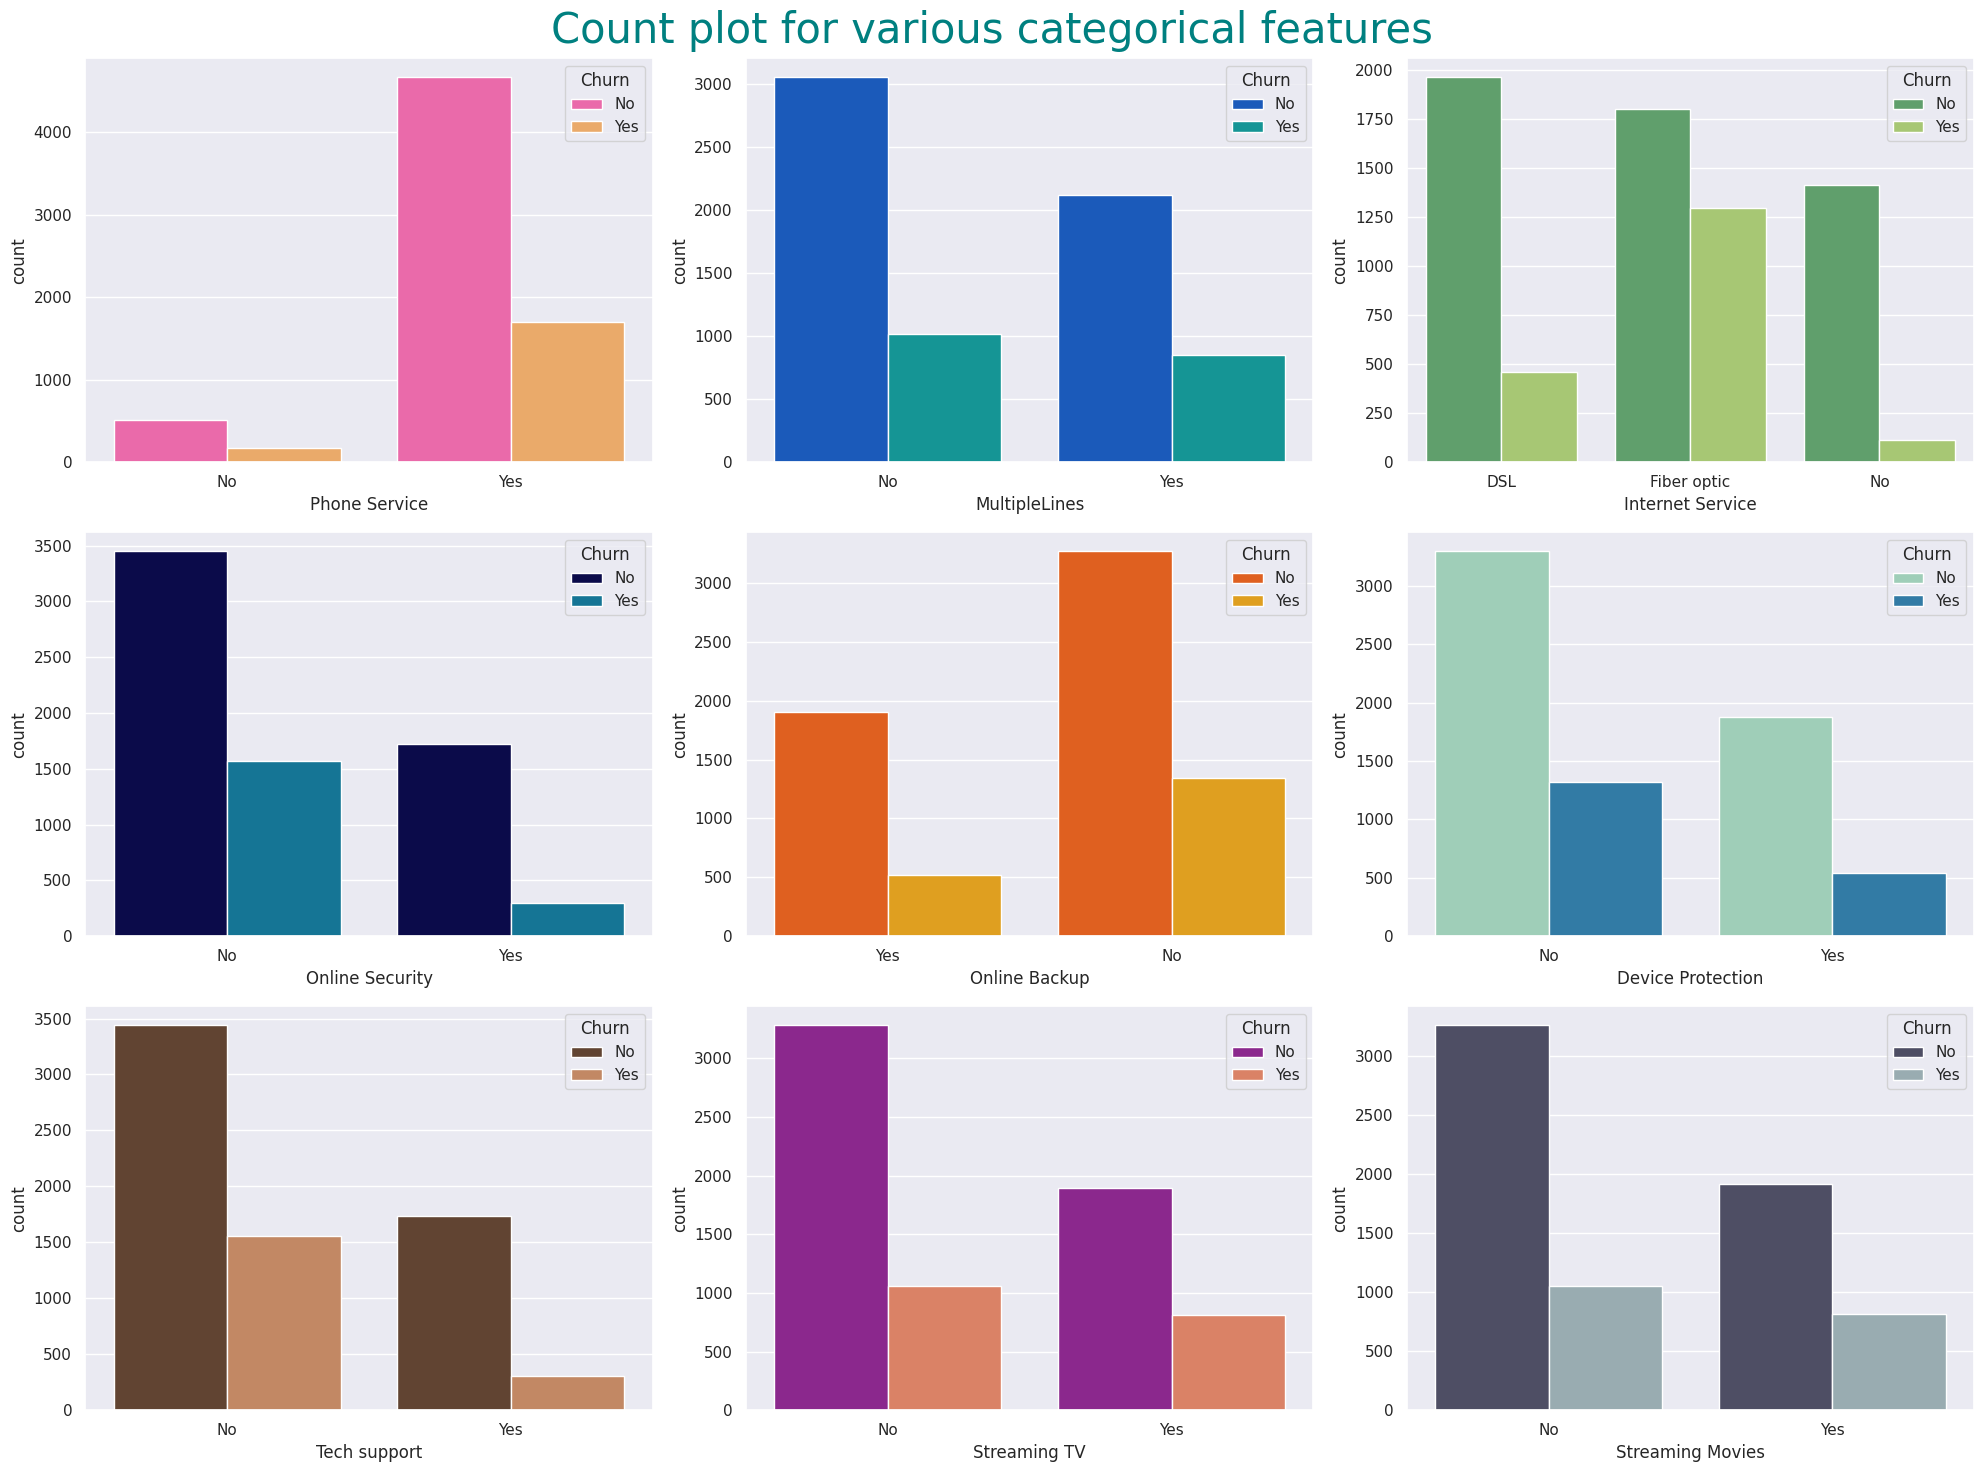

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (20, 15))

plt.suptitle('Count plot for various categorical features', fontsize = 30, color= 'teal')

ax1 = sns.countplot(x ='PhoneService', data= data, hue= 'Churn', ax= ax[0, 0], palette= 'spring')
ax1.set(xlabel = 'Phone Service')

ax2 = sns.countplot(x ='MultipleLines', data= data, hue= 'Churn', ax= ax[0, 1], palette= 'winter')
ax2.set(xlabel = 'MultipleLines')

ax3 = sns.countplot(x ='InternetService', data= data, hue= 'Churn', ax= ax[0, 2], palette= 'summer')
ax3.set(xlabel = 'Internet Service')

ax4 = sns.countplot(x ='OnlineSecurity', data= data, hue= 'Churn', ax= ax[1, 0], palette= 'ocean')
ax4.set(xlabel = 'Online Security')

ax5 = sns.countplot(x ='OnlineBackup', data= data, hue= 'Churn', ax= ax[1, 1], palette= 'autumn')
ax5.set(xlabel = 'Online Backup')

ax6 = sns.countplot(x ='DeviceProtection', data= data, hue= 'Churn', ax= ax[1, 2], palette= 'YlGnBu')
ax6.set(xlabel = 'Device Protection')

ax7 = sns.countplot(x ='TechSupport', data= data, hue= 'Churn', ax= ax[2, 0], palette= 'copper')
ax7.set(xlabel = 'Tech support')

ax8 = sns.countplot(x ='StreamingTV', data= data, hue= 'Churn', ax= ax[2, 1], palette= 'plasma')
ax8.set(xlabel = 'Streaming TV')

ax9 = sns.countplot(x ='StreamingMovies', data= data, hue= 'Churn', ax= ax[2, 2], palette= 'bone')
ax9.set(xlabel = 'Streaming Movies')

plt.tight_layout()
plt.show()


In [ ]:
data.isna().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


# **Principal Component Analysis (PCA)**

In [ ]:
from sklearn.decomposition import PCA

# Applying PCA on scaled numeric columns (only numerical features are used)
X_numeric = data[['tenure', 'MonthlyCharges', 'TotalCharges']]

# Initialize PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)

# PCA explained variance
print("Explained variance by each component: ", pca.explained_variance_ratio_)

# Add PCA components to the data
data['PCA1'] = X_pca[:, 0]
data['PCA2'] = X_pca[:, 1]

# Display the first few rows to check PCA components
print(data[['PCA1', 'PCA2']].head())


Explained variance by each component:  [0.72653838 0.25361243]
       PCA1      PCA2
0 -1.951449  0.081391
1 -0.204689  0.234349
2 -1.517937 -0.523869
3 -0.201045  0.891080
4 -1.233183 -0.966494


# skewness and outliers detection

In [ ]:
skew_df = pd.DataFrame(data.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(data[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df

,Feature,Skew,Absolute Skew
0,tenure,0.238505,0.238505
1,MonthlyCharges,-0.220477,0.220477
2,TotalCharges,0.963584,0.963584


In [ ]:
data['TotalCharges'] = np.log(data['TotalCharges'])

<ipython-input-32-53cd6ac316d5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(y=data['tenure'], x=data['Churn'], ax=ax[0], palette='Set2')
<ipython-input-32-53cd6ac316d5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.boxplot(y=data['MonthlyCharges'], x=data['Churn'], ax=ax[1], palette='Pastel1')
<ipython-input-32-53cd6ac316d5>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.boxplot(y=data['TotalCharges'], x=data['Churn'], ax=ax[2], palette='Set1')


<function matplotlib.pyplot.show(close=None, block=None)>

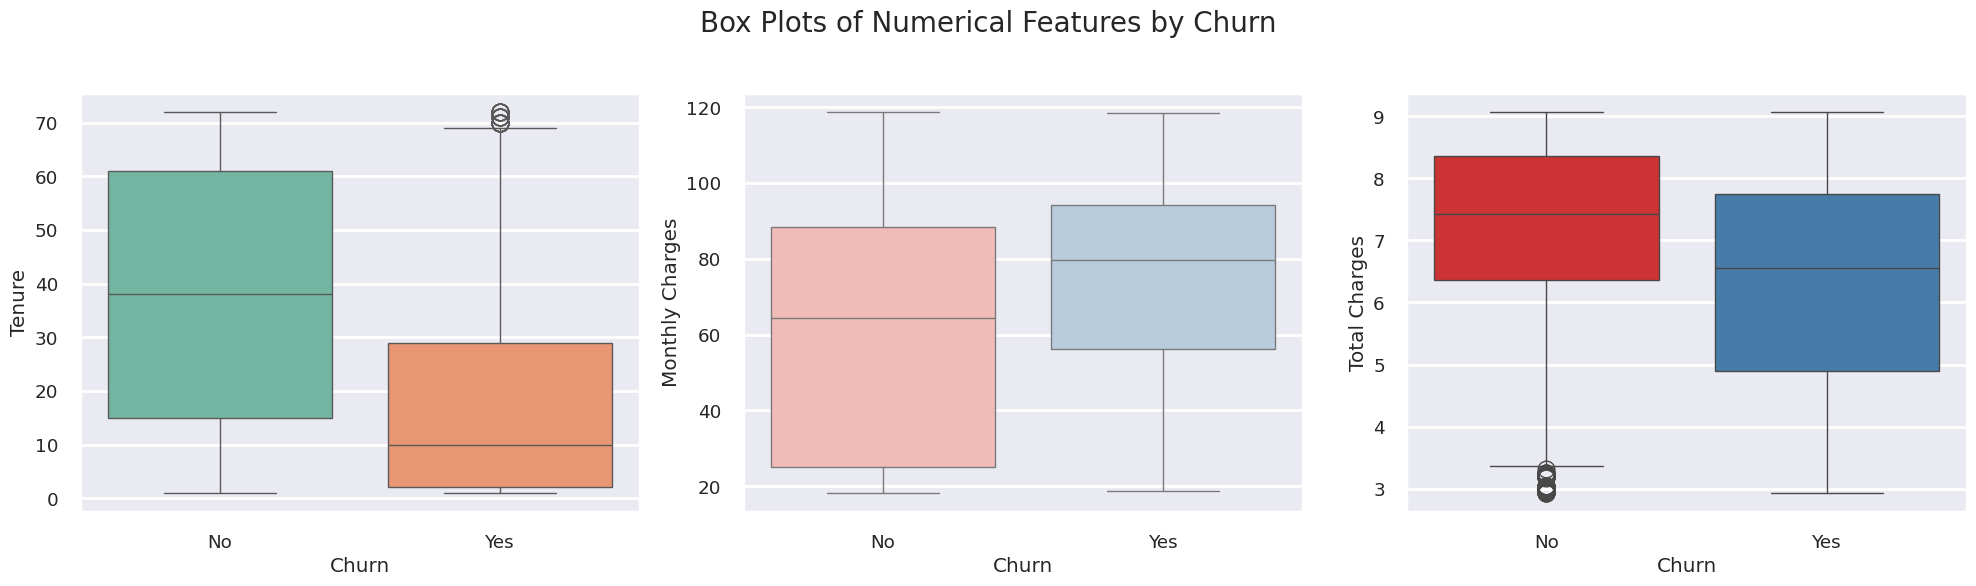

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set context for plots
sns.set_context('poster', font_scale=0.6)

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Set the title for the entire figure
plt.suptitle('Box Plots of Numerical Features by Churn', fontsize=20)

# Plot box plots with customized colors
ax1 = sns.boxplot(y=data['tenure'], x=data['Churn'], ax=ax[0], palette='Set2')
ax1.set(xlabel='Churn', ylabel='Tenure')

ax2 = sns.boxplot(y=data['MonthlyCharges'], x=data['Churn'], ax=ax[1], palette='Pastel1')
ax2.set(xlabel='Churn', ylabel='Monthly Charges')

ax3 = sns.boxplot(y=data['TotalCharges'], x=data['Churn'], ax=ax[2], palette='Set1')
ax3.set(xlabel='Churn', ylabel='Total Charges')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to accommodate suptitle

# Show plot
plt.show


# **Binary encoding**

In [ ]:
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

le = LabelEncoder()
for column in binary_columns:
    data[column] = le.fit_transform(data[column])

### **one hot encoding**

In [ ]:
dummies_payment = pd.get_dummies(data['PaymentMethod'], drop_first= True)
data = pd.concat([data, dummies_payment], axis=1)
data.drop('PaymentMethod',axis =1 , inplace= True)

## **Ordinal Encoding**

In [ ]:
internet_ordering = ['No', 'DSL', 'Fiber optic']
contract_ordering = ['Month-to-month', 'One year', 'Two year']

data['InternetService'] = data['InternetService'].apply(lambda x: internet_ordering.index(x))
data['Contract'] = data['Contract'].apply(lambda x: contract_ordering.index(x))

# **scaling**

In [ ]:
X = data.drop('Churn', axis= 1)
y = data['Churn']

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)

## **splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42)

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

Churn
0    4139
1    1495
Name: count, dtype: int64
Churn
0    1035
1     374
Name: count, dtype: int64


## **Modelling**

In [ ]:
models = {
    'logistic regression' : LogisticRegression(),
    'xgboost' : XGBClassifier(),
    'catboost' : CatBoostClassifier(verbose=0),
    'lightbgm' : LGBMClassifier(),
    'gradient boosing' : GradientBoostingClassifier(),
    'naive bayes' : GaussianNB(),
    'random forest' : RandomForestClassifier()
}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

logistic regression trained
xgboost trained
catboost trained
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
lightbgm trained
gradient boosing trained
naive bayes trained
random forest trained


## **Evaluation**

In [ ]:
results = {}

kf = KFold(n_splits= 10)

for name, model in models.items():
    result = cross_val_score(model, X_train, y_train, scoring= 'roc_auc', cv= kf)
    results[name] = result

[LightGBM] [Info] Number of positive: 1348, number of negative: 3722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265878 -> initscore=-1.015639
[LightGBM] [Info] Start training from score -1.015639
[LightGBM] [Info] Number of positive: 1351, number of negative: 3719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 21
[LightGBM] [Info] [binary:

In [ ]:
for name, result in results.items():
    print("----------------")
    print(f'{name} : {np.mean(result)}')

----------------
logistic regression : 0.8508865553194583
----------------
xgboost : 0.8205718013642068
----------------
catboost : 0.8410796939951648
----------------
lightbgm : 0.8360262959501084
----------------
gradient boosing : 0.8451788469252293
----------------
naive bayes : 0.8338557401940768
----------------
random forest : 0.8235800773347502


## **Parameter tuning**

In [ ]:
def lr_objective(trial):
    tol = trial.suggest_loguniform('tol', 1e-7, 0.1)
    C = trial.suggest_float('C', 0, 0.1)
    max_iter = trial.suggest_int('max_iter', 50, 600)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(
        solver= 'liblinear',
        penalty = penalty,
        tol= tol,
        C= C,
        max_iter= max_iter
    )

    model.fit(X_train, y_train)
    cv_score = cross_val_score(model, X_train, y_train, scoring= 'roc_auc', cv= kf)

    return np.mean(cv_score)

study = optuna.create_study(direction= 'maximize')
study.optimize(lr_objective, n_trials= 100)

[I 2024-09-08 19:11:01,156] A new study created in memory with name: no-name-0efac3da-1a35-4740-8275-acec319de091
<ipython-input-44-df72d73ccb67>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-7, 0.1)
[I 2024-09-08 19:11:01,359] Trial 0 finished with value: 0.850440529102154 and parameters: {'tol': 0.05823054161332095, 'C': 0.03986881752671854, 'max_iter': 372, 'penalty': 'l2'}. Best is trial 0 with value: 0.850440529102154.
<ipython-input-44-df72d73ccb67>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-7, 0.1)
[I 2024-09-08 19:11:01,526] Trial 1 finished with value: 0.8477654338299067 

In [ ]:
study.best_params

{'tol': 0.00888429650708655,
 'C': 0.09399522706301541,
 'max_iter': 211,
 'penalty': 'l1'}

In [ ]:
lr = LogisticRegression(
    solver = 'liblinear',
    tol = 0.008408625396645686,
    C = 0.08440490508701622,
    max_iter = 434,
    penalty = 'l1')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)[:, 1]

In [ ]:
print("Actual values    :", y_test.values[:20])
print("Predicted values :", y_pred[:20])

Actual values    : [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
Predicted values : [0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0]


## here we can see the difference between actual and predicted values

In [ ]:
predictions = pd.DataFrame({'Probability of Customer Churning': y_pred_prob, 'Probability of customer not churning' : 1 - y_pred_prob})
predictions.head()

,Probability of Customer Churning,Probability of customer not churning
0,0.059138,0.940862
1,0.681336,0.318664
2,0.065112,0.934888
3,0.325399,0.674601
4,0.033453,0.966547


In [ ]:
print('ROC AUC Score:', round(roc_auc_score(y_test, y_pred_prob), 3))

ROC AUC Score: 0.849


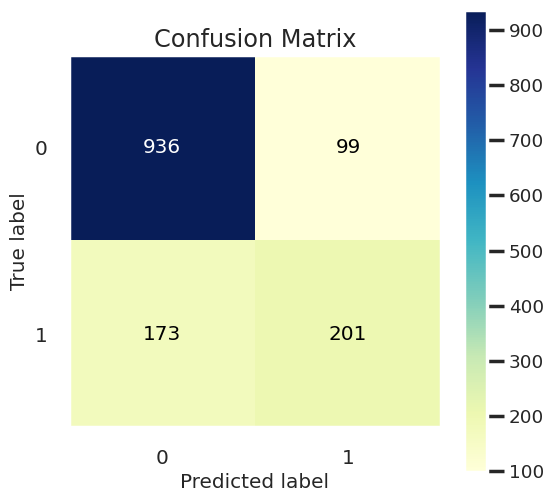

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(6,6), cmap= 'YlGnBu');


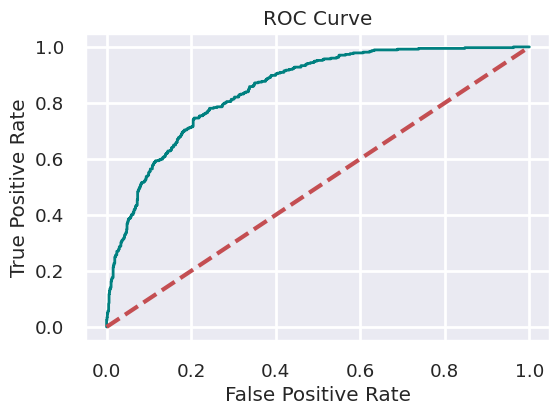

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2, color= 'teal')
plt.plot([0,1], [0,1], 'r--' )
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

## **LETS TRY WITH ANN**

In [ ]:
X_train.shape

(5634, 21)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(21,)),  # Correct input shape
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

BATCH_SIZE = 100
EPOCHS = 10

history = model.fit(
    X_train,
    y_train,
    validation_split=0.20,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping]
)


In [ ]:
history.history.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

### **Plotting Results**

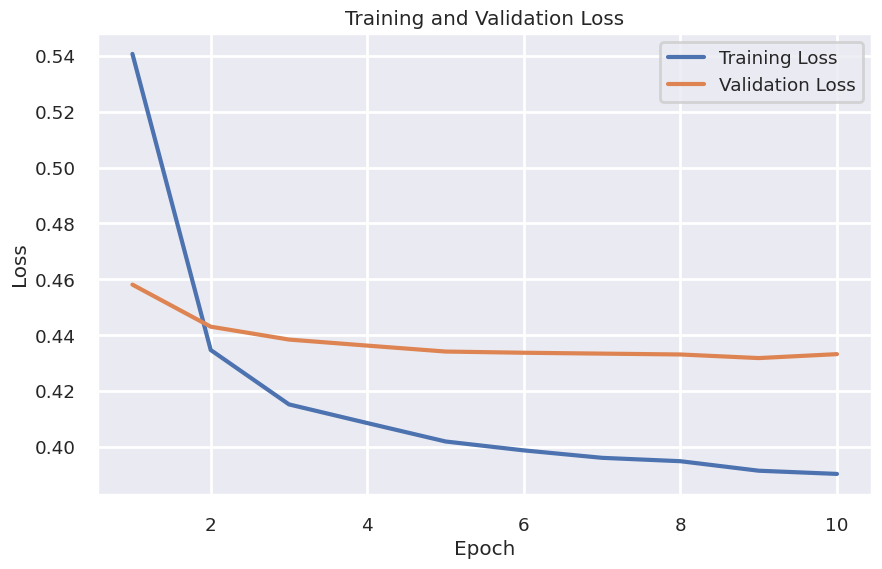

In [ ]:
plt.figure(figsize=(10, 6))

epochs = range(1, EPOCHS + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
np.argmin(val_loss)

8

In [ ]:
model.evaluate(X_test, y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8378 - loss: 0.4273


[0.41894426941871643, 0.8432599902153015]

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Assuming X_train and y_train are already loaded

# Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Updated model with more units and dropout layers
model = tf.keras.Sequential([
    tf.keras.Input(shape=(21,)),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    Dropout(0.3),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=10, verbose=1,
    mode='auto', restore_best_weights=True
)

# Compile model with a custom learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

BATCH_SIZE = 100
EPOCHS = 50  # Increased epochs

history = model.fit(
    X_train_scaled,  # Use normalized data
    y_train,
    validation_split=0.20,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc: 0.5956 - loss: 0.6130 - val_auc: 0.7959 - val_loss: 0.4779
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8107 - loss: 0.4636 - val_auc: 0.8182 - val_loss: 0.4428
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8263 - loss: 0.4467 - val_auc: 0.8239 - val_loss: 0.4366
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8423 - loss: 0.4231 - val_auc: 0.8279 - val_loss: 0.4335
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8438 - loss: 0.4170 - val_auc: 0.8291 - val_loss: 0.4318
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8479 - loss: 0.4099 - val_auc: 0.8305 - val_loss: 0.4322
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8468 - loss: 0.4132 - val_auc: 0.8302 - val_loss: 0.4318
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8468 - loss: 0.4171 - val_auc: 0.8300 - val_loss: 0.4314
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8467 - loss: 

In [ ]:
history.history.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

In [ ]:
np.argmin(val_loss)


12

In [ ]:
model.evaluate(X_test, y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8418 - loss: 0.4219


[0.41628047823905945, 0.8447750806808472]

In [ ]:
# Assuming X_test and y_test are the test datasets

# Scale the test data using the same scaler used for training
X_test_scaled = scaler.transform(X_test)

# Evaluate the model on the test set
test_loss, test_auc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test AUC: {test_auc}")


Test Loss: 0.4167633056640625
Test AUC: 0.8451535701751709


In [ ]:
# Get predictions for test data
y_pred = model.predict(X_test_scaled)
y_pred_class = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class (0 or 1)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


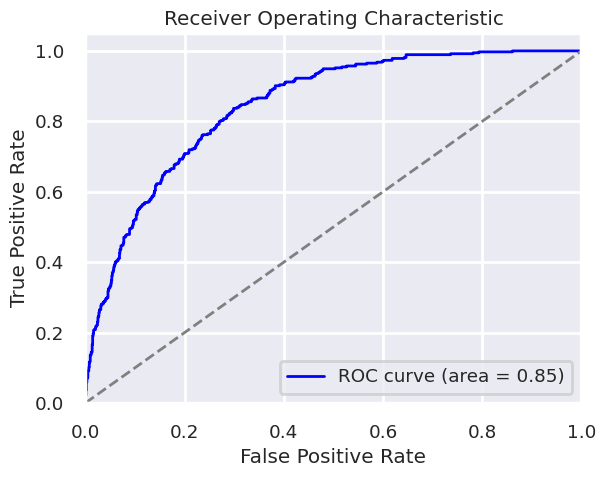

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# Updated model architecture
model = tf.keras.Sequential([
    tf.keras.Input(shape=(21,)),
    tf.keras.layers.Dense(128),
    BatchNormalization(),  # Added Batch Normalization
    LeakyReLU(),  # Changed activation function
    Dropout(0.4),  # Adjusted Dropout rate
    tf.keras.layers.Dense(64),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),
    tf.keras.layers.Dense(32),
    BatchNormalization(),
    LeakyReLU(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0005, patience=15, verbose=1,
    mode='auto', restore_best_weights=True
)

# Compile model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0003),  # Reduced learning rate slightly
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Train the model
history = model.fit(
    X_train_scaled,  # Use normalized data
    y_train,
    validation_split=0.20,
    batch_size=BATCH_SIZE,
    epochs=100,  # Increased epochs
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - auc: 0.5544 - loss: 0.7653 - val_auc: 0.8094 - val_loss: 0.5835
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.7694 - loss: 0.5942 - val_auc: 0.8178 - val_loss: 0.5457
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.7832 - loss: 0.5597 - val_auc: 0.8210 - val_loss: 0.5265
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8084 - loss: 0.5138 - val_auc: 0.8236 - val_loss: 0.5060
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8293 - loss: 0.4764 - val_auc: 0.8245 - val_loss: 0.4882
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8282 - loss: 0.4670 - val_auc: 0.8250 - val_loss: 0.4740
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.8250 - loss: 0.4546 - val_auc: 0.8255 - val_loss: 0.4647
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8171 - loss: 0.4547 - val_auc: 0.8259 - val_loss: 0.4607
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.837

In [ ]:
np.argmin(val_loss)


12

In [ ]:
history.history.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

In [ ]:
model.evaluate(X_test, y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8445 - loss: 0.4216


[0.41795814037323, 0.8461326360702515]

In [ ]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

# Assuming X_train and y_train are already loaded and scaled
# Balancing the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Calculate class weights to handle class imbalance
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)))

# Updated model architecture with deeper layers and L2 regularization
model = tf.keras.Sequential([
    tf.keras.Input(shape=(21,)),
    tf.keras.layers.Dense(256, kernel_regularizer=l2(0.001)),  # Increased units, L2 regularization
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),  # Increased dropout rate
    tf.keras.layers.Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    tf.keras.layers.Dense(64, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0005, patience=20, verbose=1,
    mode='auto', restore_best_weights=True
)

# Compile model with RMSprop optimizer
model.compile(
    optimizer=RMSprop(learning_rate=0.0003),  # Switched to RMSprop optimizer
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Train the model
history = model.fit(
    X_train_resampled,  # Use resampled data
    y_train_resampled,
    validation_split=0.20,
    batch_size=BATCH_SIZE,
    epochs=150,  # Increased epochs
    verbose=1,
    class_weight=class_weights_dict,  # Use class weights for imbalance
    callbacks=[early_stopping]
)


Epoch 1/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - auc: 0.7021 - loss: 1.0066 - val_auc: 0.0000e+00 - val_loss: 0.7243
Epoch 2/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.8136 - loss: 0.8420 - val_auc: 0.0000e+00 - val_loss: 0.6962
Epoch 3/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8154 - loss: 0.8074 - val_auc: 0.0000e+00 - val_loss: 0.7136
Epoch 4/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8202 - loss: 0.7882 - val_auc: 0.0000e+00 - val_loss: 0.7402
Epoch 5/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.8177 - loss: 0.7739 - val_auc: 0.0000e+00 - val_loss: 0.7377
Epoch 6/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.8318 - loss: 0.7511 - val_auc: 0.0000e+00 - val_loss: 0.7385
Epoch 7/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.8422 - loss: 0.7285 - val_auc: 0.0000e+00 - val_loss: 0.7428
Epoch 8/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.8358 - loss: 0.7303 - val_auc: 0.0000e+00 - val_loss: 0.7395
Epoch 9/150
67/67 ━━━━━━━━━━━━━

In [ ]:
# Evaluate the model on the validation data
val_loss, val_auc = model.evaluate(X_train_scaled, y_train, verbose=1)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation AUC: {val_auc:.4f}')


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8836 - loss: 0.4051
Validation Loss: 0.4182
Validation AUC: 0.8740


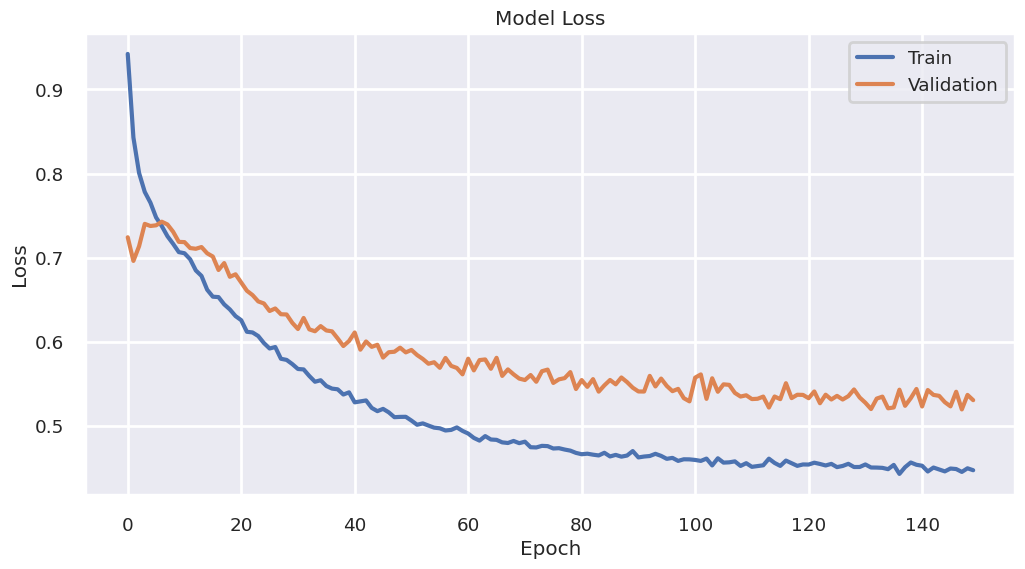

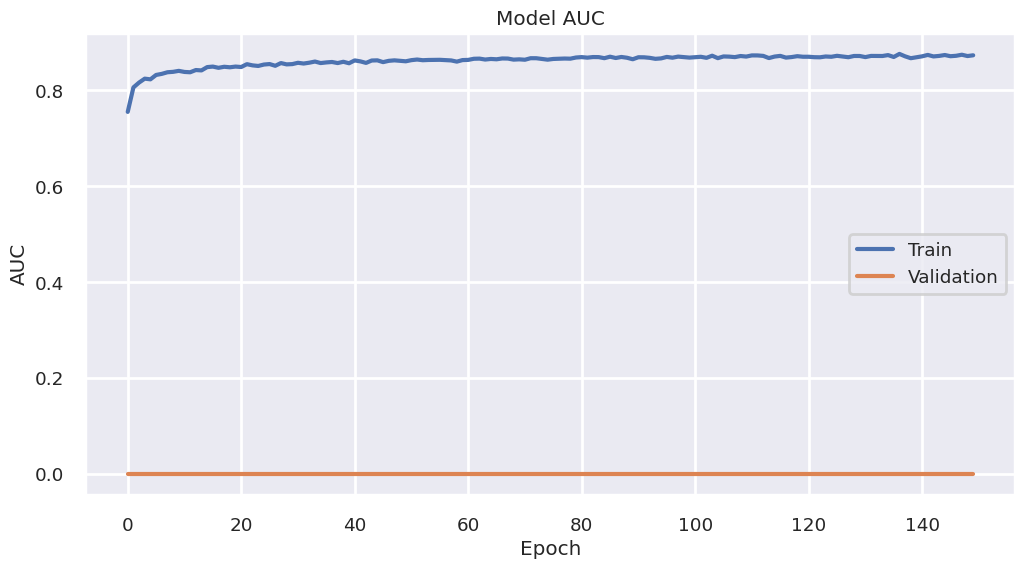

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot training & validation AUC values
plt.figure(figsize=(12, 6))
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train', 'Validation'])
plt.show()


In [ ]:
model.save('ann_model1.h5')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow as tf

# Assuming X_train and y_train are already loaded and scaled
# Balancing the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

def build_model(hp):
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=(21,)))

    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            kernel_regularizer=l2(0.001)
        ))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_auc',
    max_epochs=150,
    factor=3,
    directory='kt_dir',
    project_name='model_tuning'
)

# Perform the hyperparameter search
tuner.search(
    X_train_resampled,
    y_train_resampled,
    epochs=150,
    batch_size=BATCH_SIZE,
    validation_split=0.2
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_loss, test_auc = best_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC: {test_auc:.4f}')


Trial 254 Complete [00h 01m 50s]
val_auc: 0.0

Best val_auc So Far: 0.0
Total elapsed time: 01h 05m 37s
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6047 - loss: 0.7845
Test Loss: 0.7871
Test AUC: 0.6039


In [ ]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow as tf

# Ensure X_train and y_train are already loaded and scaled
# Balancing the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Calculate class weights to handle class imbalance
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)))

# Check shapes of training and validation sets
train_size = int(0.80 * len(X_train_resampled))
val_size = len(X_train_resampled) - train_size
print(f"Training data shape: {X_train_resampled[:train_size].shape}")
print(f"Validation data shape: {X_train_resampled[train_size:].shape}")

# Updated model architecture with deeper layers and L2 regularization
model = tf.keras.Sequential([
    tf.keras.Input(shape=(21,)),
    tf.keras.layers.Dense(512, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),
    tf.keras.layers.Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    tf.keras.layers.Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    tf.keras.layers.Dense(64, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', min_delta=0.0005, patience=10, verbose=1,  # Adjusted patience and monitor metric
    mode='max', restore_best_weights=True
)

# Compile model with RMSprop optimizer
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),  # Adjusted learning rate
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Train the model
history = model.fit(
    X_train_resampled,  # Use resampled data
    y_train_resampled,
    validation_split=0.20,  # Ensure proper validation split
    batch_size=64,  # Adjusted batch size
    epochs=150,  # Increased epochs
    verbose=1,
    class_weight=class_weights_dict,  # Use class weights for imbalance
    callbacks=[early_stopping]
)


Training data shape: (6622, 21)
Validation data shape: (1656, 21)
Epoch 1/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - auc: 0.7134 - loss: 1.3104 - val_auc: 0.0000e+00 - val_loss: 1.1788
Epoch 2/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8038 - loss: 1.2146 - val_auc: 0.0000e+00 - val_loss: 1.1002
Epoch 3/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8185 - loss: 1.1898 - val_auc: 0.0000e+00 - val_loss: 1.0584
Epoch 4/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - auc: 0.8245 - loss: 1.1670 - val_auc: 0.0000e+00 - val_loss: 1.0506
Epoch 5/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc: 0.8320 - loss: 1.1446 - val_auc: 0.0000e+00 - val_loss: 1.0487
Epoch 6/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8333 - loss: 1.1281 - val_auc: 0.0000e+00 - val_loss: 1.0556
Epoch 7/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8262 - loss: 1.1272 - val_auc: 0.0000e+00 - val_loss: 1.0499
Epoch 8/150
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8261 - l

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# Assuming X_train and y_train are already loaded

# Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Balancing the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Calculate class weights to handle class imbalance
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)))

# Updated model with more layers and regularization
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_resampled.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Increased units and L2 regularization
    Dropout(0.4),  # Increased dropout rate
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=10, verbose=1,
    mode='auto', restore_best_weights=True
)

# Compile model with Adam optimizer and a custom learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0003),  # Adjusted learning rate
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Training parameters
BATCH_SIZE = 64  # Adjusted batch size
EPOCHS = 100  # Increased epochs

# Train the model
history = model.fit(
    X_train_resampled,  # Use resampled data
    y_train_resampled,
    validation_split=0.20,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weights_dict,  # Use class weights for imbalance
    callbacks=[early_stopping]
)

# Evaluate the model
X_test_scaled = scaler.transform(X_test)
loss, auc = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test AUC: {auc}')

# Predict and analyze results
y_pred = model.predict(X_test_scaled)
y_pred_class = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.6645 - loss: 0.9484 - val_auc: 0.0000e+00 - val_loss: 0.9461
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8136 - loss: 0.8232 - val_auc: 0.0000e+00 - val_loss: 0.8996
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8341 - loss: 0.7866 - val_auc: 0.0000e+00 - val_loss: 0.8594
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8358 - loss: 0.7627 - val_auc: 0.0000e+00 - val_loss: 0.8100
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8507 - loss: 0.7250 - val_auc: 0.0000e+00 - val_loss: 0.7936
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8410 - loss: 0.7231 - val_auc: 0.0000e+00 - val_loss: 0.7898
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8588 - loss: 0.6831 - val_auc: 0.0000e+00 - val_loss: 0.7907
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8620 - loss: 0.6640 - val_auc: 0.0000e+00 - val_loss: 0.7304
Epoch 9/100
104/

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# Assuming X_train and y_train are already loaded

# Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Balancing the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Calculate class weights to handle class imbalance
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)))

# Updated model with more layers and regularization
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_resampled.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Increased units and L2 regularization
    Dropout(0.4),  # Increased dropout rate
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=10, verbose=1,
    mode='auto', restore_best_weights=True
)

# Compile model with Adam optimizer and a custom learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0003),  # Adjusted learning rate
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Training parameters
BATCH_SIZE = 64  # Adjusted batch size
EPOCHS = 100  # Increased epochs

# Train the model
history = model.fit(
    X_train_resampled,  # Use resampled data
    y_train_resampled,
    validation_split=0.20,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weights_dict,  # Use class weights for imbalance
    callbacks=[early_stopping]
)

# Print the history to debug metrics
print("Training History:")
print(history.history)

# Evaluate the model on a separate test set (assuming X_test and y_test are available)
X_test_scaled = scaler.transform(X_test)
loss, auc = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test AUC: {auc}')

# Predict and analyze results
y_pred = model.predict(X_test_scaled)
y_pred_class = (y_pred > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - auc: 0.6270 - loss: 0.9801 - val_auc: 0.0000e+00 - val_loss: 0.9925
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.8233 - loss: 0.8011 - val_auc: 0.0000e+00 - val_loss: 0.8974
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8356 - loss: 0.7612 - val_auc: 0.0000e+00 - val_loss: 0.8332
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8424 - loss: 0.7362 - val_auc: 0.0000e+00 - val_loss: 0.8291
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8544 - loss: 0.7000 - val_auc: 0.0000e+00 - val_loss: 0.7802
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8509 - loss: 0.6877 - val_auc: 0.0000e+00 - val_loss: 0.8443
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8526 - loss: 0.6685 - val_auc: 0.0000e+00 - val_loss: 0.7634
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8662 - loss: 0.6322 - val_auc: 0.0000e+00 - val_loss: 0.7292
Epoch 9/100
104